In [1]:
import re
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from wordcloud import WordCloud

from habr_article_analyzer import data, data_loader
from habr_article_analyzer.data import DEFAULT_FULL_PATH
from habr_article_analyzer.settings import settings

# Exploratory data analysis. Data visualization.

*Author: Nikita Zolin*

**Remark.** Our main task in this project is to predict a hub based on the part of the text. We will not use any information about the article such as date, author, etc. However, we still analyse such fields just to understand the data better.

**Remark 2.** We can't keep the whole dataset in memory since it's too large. We will use `HabrDataset` which allows to fetch only light-weight columns.

## Numerical columns basic analysis

For the first section let's stick to the numerical columns such as statistics, reading_time and etc.

In [2]:
data.download_dataset(DEFAULT_FULL_PATH)

In [3]:
columns_to_load = ["id", "title", "text_markdown", "author", "statistics"]

dataset = data_loader.HabrDataset(
    path=DEFAULT_FULL_PATH, columns=columns_to_load, batch_size=50_000
)

all_batches = []
for batch_df in dataset:
    batch_df["title_length"] = batch_df["title"].str.len()
    batch_df["text_length"] = batch_df["text_markdown"].str.len()
    batch_df = batch_df.drop(columns=["title", "text_markdown"])

    stats_df = batch_df["statistics"].apply(pd.Series)
    stats_df = stats_df.rename(columns=lambda x: f"stats_{x}")

    batch_df = pd.concat([batch_df.drop(columns=["statistics"]), stats_df], axis=1)

    all_batches.append(batch_df)

full_df = pd.concat(all_batches, ignore_index=True)
full_df.head()

Reading dataset: 302049it [02:38, 1908.09it/s]


,id,author,title_length,text_length,stats_commentsCount,stats_favoritesCount,stats_readingCount,stats_score,stats_votesCount,stats_votesCountPlus,stats_votesCountMinus
0,12730,Юлия Благовещенская (skazala),41,608,23,1,1542,7,15,11,4
1,558542,mobileSimbirSoft,55,10237,3,17,7229,6,6,6,0
2,141150,Анатолий Ализар (alizar),62,1830,10,22,1711,20,24,22,2
3,530546,SearchInform_team,95,6698,1,7,2737,8,8,8,0
4,598357,Никита Цаплин (ntsaplin),82,9667,101,78,35519,79,83,81,2


Let's look at some basic statistics.

In [4]:
full_df.describe()

,id,title_length,text_length,stats_commentsCount,stats_favoritesCount,stats_readingCount,stats_score,stats_votesCount,stats_votesCountPlus,stats_votesCountMinus
count,302049.000000,302049.000000,302049.000000,302049.000000,302049.000000,3.020490e+05,302049.000000,302049.000000,302049.000000,302049.000000
mean,324681.610898,53.539644,7449.095379,33.553417,52.640207,1.853326e+04,21.879023,37.642028,29.759244,7.880221
std,210431.252045,23.917111,9124.073436,67.451564,115.584833,4.383586e+04,32.902461,547.708788,275.350250,273.333629
min,1.000000,1.000000,5.000000,0.000000,0.000000,5.900000e+01,-194.000000,0.000000,-20.000000,-39.000000
25%,131406.000000,36.000000,1876.000000,4.000000,5.000000,2.112000e+03,5.000000,11.000000,8.000000,1.000000
50%,318104.000000,51.000000,4797.000000,13.000000,20.000000,6.944000e+03,12.000000,20.000000,16.000000,3.000000
75%,498800.000000,69.000000,9985.000000,36.000000,56.000000,1.830800e+04,27.000000,40.000000,33.000000,7.000000
max,716000.000000,219.000000,773489.000000,2928.000000,9260.000000,5.591725e+06,1448.000000,65535.000000,32767.000000,32767.000000


We can see that for some columns `mean` is closer to `q3` instead of `q2`, which may signal about heavy tail. We also see that `median` article has quite a lot of comments and readings.

We also see some suspicious statistics. For example:

1) Negative values in `stats_votesCountPlus` and `stats_votesCountMinus`. We believe that they can't be negative so we need to handle them.
2) `2**15 - 1` in the same columns. It might be the result of the clamp, which we also don't know how to interpolate.

To choose the way to handle such rows let's check the amount of them:

In [5]:
mask_weird = (
    (full_df["stats_votesCountPlus"] < 0)
    | (full_df["stats_votesCountMinus"] < 0)
    | (full_df["stats_votesCountPlus"].astype(np.int64) == 2**15 - 1)
    | (full_df["stats_votesCountMinus"].astype(np.int64) == 2**15 - 1)
)

mask_weird.sum()

np.int64(60)

We see that there are only 60 rows for 300k, so let's just remove them. Here we should keep in mind that such big number can mean that there are more votes and we are removing heavy tails. However, since we can't identify the actual reason, it's better to follow the safe way.

In [6]:
filtered_df = full_df[~mask_weird]

In [7]:
filtered_df.isna().sum()

id                        0
author                   35
title_length              0
text_length               0
stats_commentsCount       0
stats_favoritesCount      0
stats_readingCount        0
stats_score               0
stats_votesCount          0
stats_votesCountPlus      0
stats_votesCountMinus     0
dtype: int64

We have them only in `author` column which means that author was anonymous. We will keep it in mind if we include this column to our analysis, but for now let's get back to numerical columns.

Let's start with pairplot.

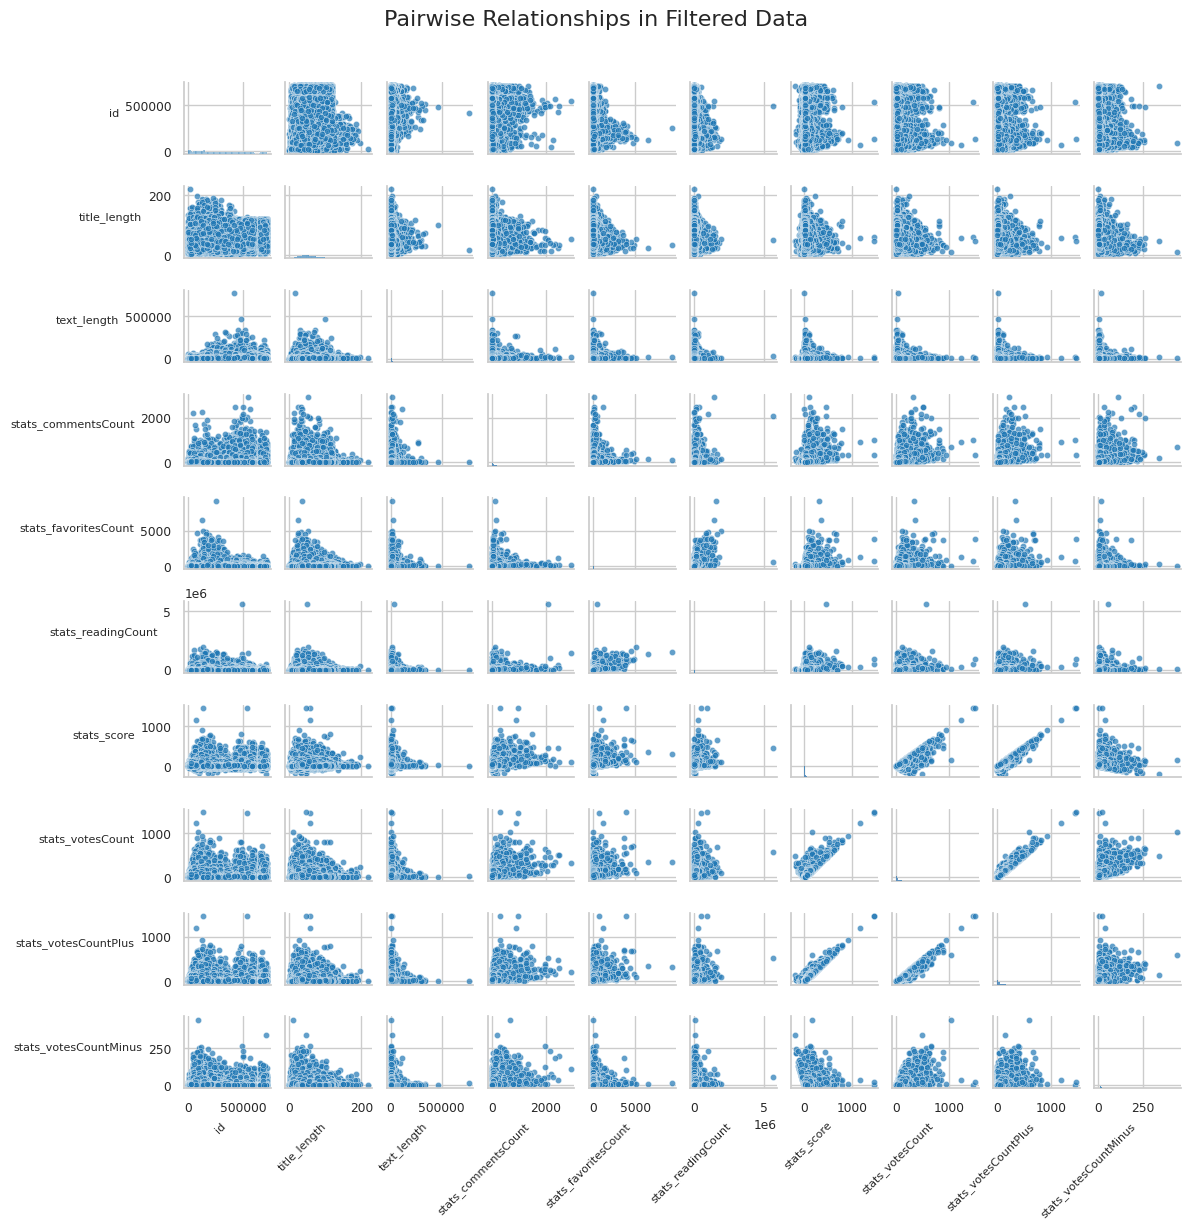

In [8]:
def draw_pairplot(df: pd.DataFrame) -> None:
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=0.8)

    pair_plot = sns.pairplot(
        df, diag_kind="hist", corner=False, plot_kws={"alpha": 0.7, "s": 20}
    )

    pair_plot.fig.set_size_inches(12, 12)

    for i, ax_row in enumerate(pair_plot.axes):
        for j, ax in enumerate(ax_row):
            if ax is not None:
                if i == len(pair_plot.axes) - 1:
                    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha="right", fontsize=8)
                if j == 0:
                    ax.set_ylabel(ax.get_ylabel(), rotation=0, ha="right", fontsize=8)

    pair_plot.fig.suptitle(
        "Pairwise Relationships in Filtered Data", fontsize=16, y=1.02
    )
    pair_plot.fig.tight_layout()

    plt.show()


draw_pairplot(filtered_df)

Let's discuss the most obvious graphs. We see almost linear dependency between `stats_score`, `stats_votesCount` and `stats_votesCountPlus` which gives us intuition how the `score` is calculated. It would be pretty useful if our goal was to predict the `stats_score`.

We can notice, that if `text_length` increases significantly, all the stats will decrease. It shows us, that most people don't read long articles on Habr. We also can notice the similar problem for `title_length`.

We can also notice some more weird points which has incredibly big values for some columns. Let's also filter them. We will excluse long texts and some suspiciously high statistics.

In [9]:
filtered_df = filtered_df[
    (filtered_df["text_length"] <= 450_000)
    & (filtered_df["stats_readingCount"] < 5_000_000)
    & (filtered_df["stats_favoritesCount"] < 5_300)
]

Let's take a look at the pairplot again.

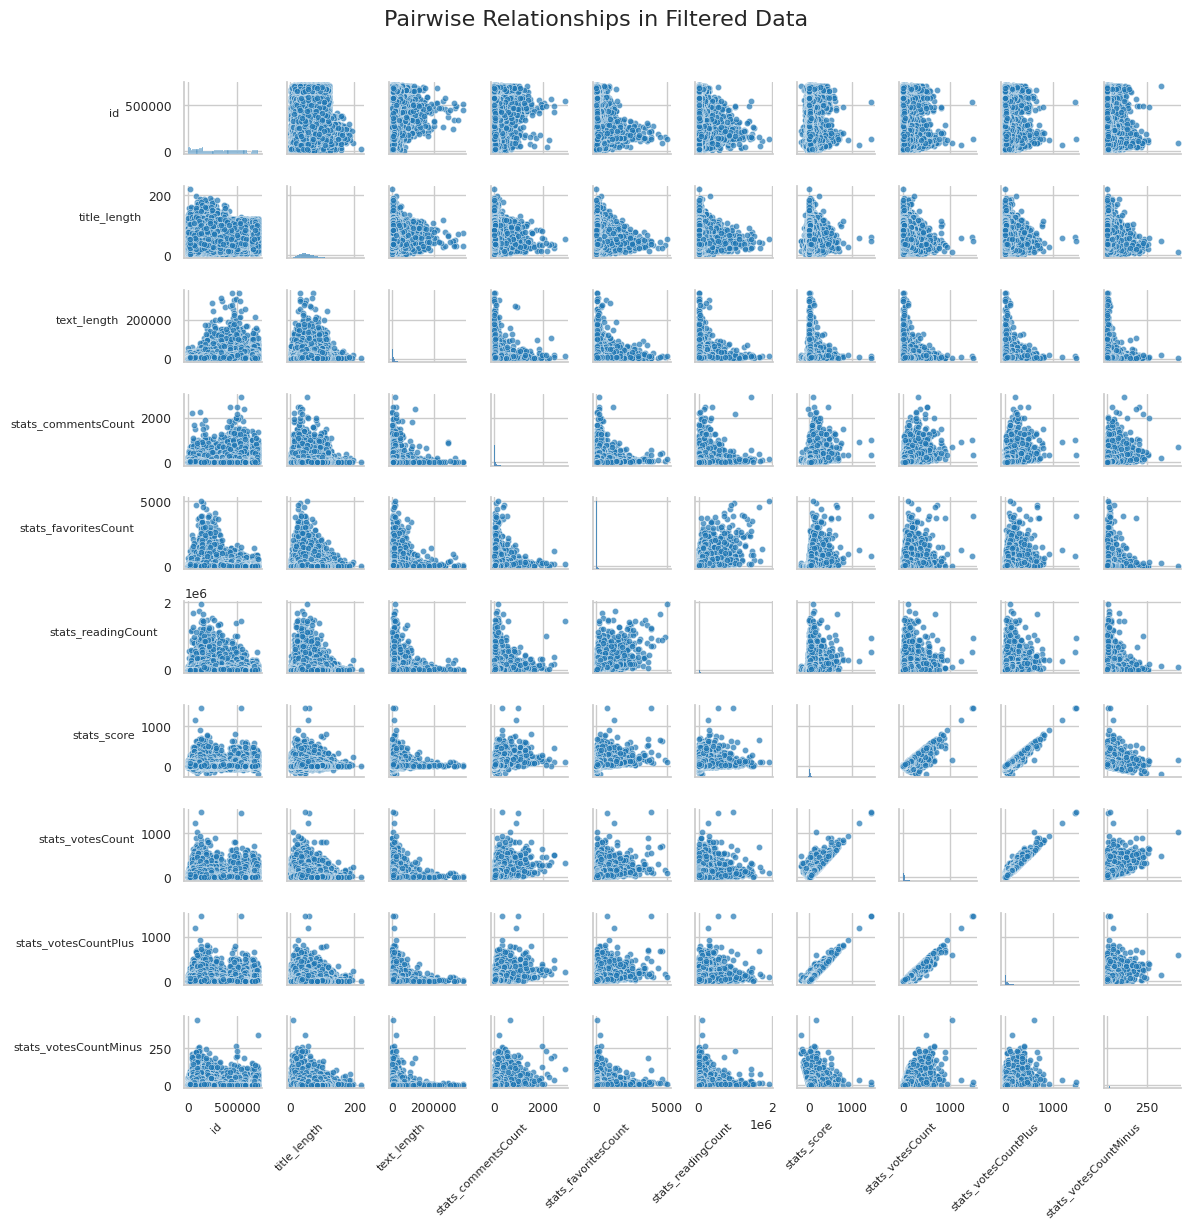

In [10]:
draw_pairplot(filtered_df)

Looks much better now. Let's save id from filtered data so we can reuse it in the future.

In [11]:
filtered_df.id.to_csv(settings.data_dir / "interim/filtered_indexes.csv")

## Target-column analysis

We already filtered the dataset based on numerical features, but let's also consider other. Our goal is to predict a hub, so we are interested in getting some knowledge about this column.

Let's set a clear purpose for such section. We will formulate it in the following two questions:

- Are the classes balanced?
- Are distrubitions for numerical features the same among different hubs?

Let's download dataset again, but with `hubs`.

In [12]:
columns_to_load = ["id", "text_markdown", "statistics", "hubs"]

dataset = data_loader.HabrDataset(
    path=DEFAULT_FULL_PATH, columns=columns_to_load, batch_size=50_000
)

all_batches = []
for batch_df in dataset:
    batch_df["text_length"] = batch_df["text_markdown"].str.len()
    batch_df = batch_df.drop(columns=["text_markdown"])

    stats_df = batch_df["statistics"].apply(pd.Series)
    stats_df = stats_df.rename(columns=lambda x: f"stats_{x}")

    batch_df = pd.concat([batch_df.drop(columns=["statistics"]), stats_df], axis=1)

    all_batches.append(batch_df)

full_df = pd.concat(all_batches, ignore_index=True)
full_df.head()

Reading dataset: 302049it [02:36, 1927.83it/s]


,id,hubs,text_length,stats_commentsCount,stats_favoritesCount,stats_readingCount,stats_score,stats_votesCount,stats_votesCountPlus,stats_votesCountMinus
0,12730,[itcompanies],608,23,1,1542,7,15,11,4
1,558542,"[simbirsoft, mobile_dev, android_dev, apps_des...",10237,3,17,7229,6,6,6,0
2,141150,"[microformats, sw]",1830,10,22,1711,20,24,22,2
3,530546,"[searchinform, infosecurity]",6698,1,7,2737,8,8,8,0
4,598357,"[ruvds, s_admin, dwh, pm, hardware]",9667,101,78,35519,79,83,81,2


Filter it using ids from previous section.

In [13]:
filtered_ids = pd.read_csv(
    settings.data_dir / "interim/filtered_indexes.csv", index_col=0
)["id"]

filtered_df = full_df[full_df.id.isin(filtered_ids)].copy()

Let's check how many hubs are there.

In [14]:
all_hubs = list(chain.from_iterable(filtered_df["hubs"]))
hub_counts = Counter(all_hubs)

hub_counts.most_common(10)

[('closet', 27447),
 ('itcompanies', 20670),
 ('infosecurity', 17701),
 ('programming', 17303),
 ('webdev', 14386),
 ('popular_science', 14359),
 ('javascript', 8668),
 ('gadgets', 8666),
 ('finance', 7307),
 ('business-laws', 7285)]

Let's choose couple of them and compare the distributions. 

In [15]:
hubs_for_analysis = [
    "infosecurity",
    "webdev",
    "popular_science",
    "finance",
    "business-laws",
]

We can just draw the distributions for different hubs.

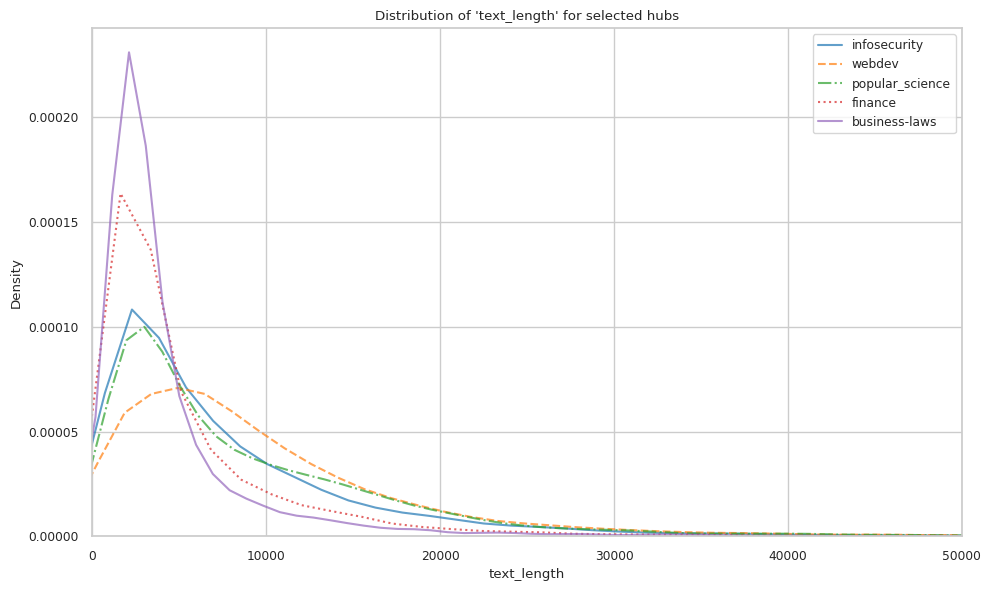

In [16]:
def plot_hub_distributions(
    df, hubs, column_name, kind="kde", figsize=(10, 6), xlim=None
):
    """
    Plot distributions of a column for selected hubs.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)

    palette = sns.color_palette("tab10", n_colors=len(hubs))
    linestyles = ["-", "--", "-.", ":"] * ((len(hubs) // 4) + 1)

    for i, hub in enumerate(hubs):
        hub_df = df[df["hubs"].apply(lambda x: hub in x)]
        if hub_df.empty:
            continue

        if kind == "kde":
            sns.kdeplot(
                data=hub_df,
                x=column_name,
                label=hub,
                color=palette[i],
                linestyle=linestyles[i],
                fill=False,
                alpha=0.7,
            )
        elif kind == "hist":
            sns.histplot(
                data=hub_df,
                x=column_name,
                label=hub,
                color=palette[i],
                alpha=0.5,
                bins=30,
            )

    plt.title(f"Distribution of '{column_name}' for selected hubs")
    plt.xlabel(column_name)
    plt.ylabel("Density" if kind == "kde" else "Count")

    if xlim:
        plt.xlim(xlim)

    plt.legend()
    plt.tight_layout()
    plt.show()


plot_hub_distributions(
    filtered_df, hubs_for_analysis, "text_length", xlim=(-10, 50_000)
)

We can see that for finance and business-laws the length is the shortest in average, while for webdev it is the longest among the selected hubs.

Let's check the statistics.

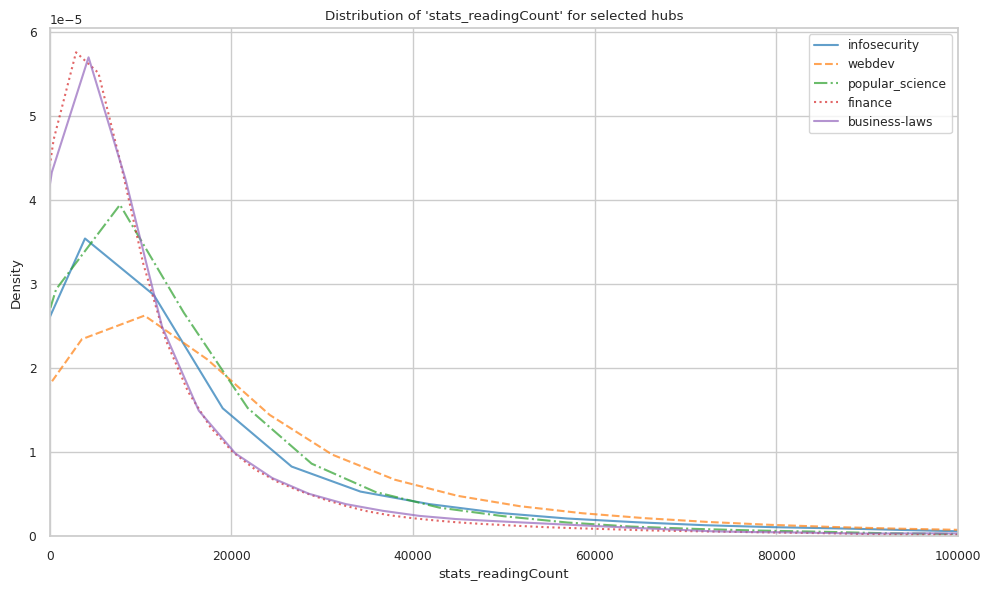

In [17]:
plot_hub_distributions(
    filtered_df, hubs_for_analysis, "stats_readingCount", xlim=(-10, 100_000)
)

We also see that `webdev` is the most popular topic from the selected. But what's more important, topic's which are not related to IT or popular science directly (finances and business-laws) are the least popular even though these hubs are the most common. The same picture for the score:

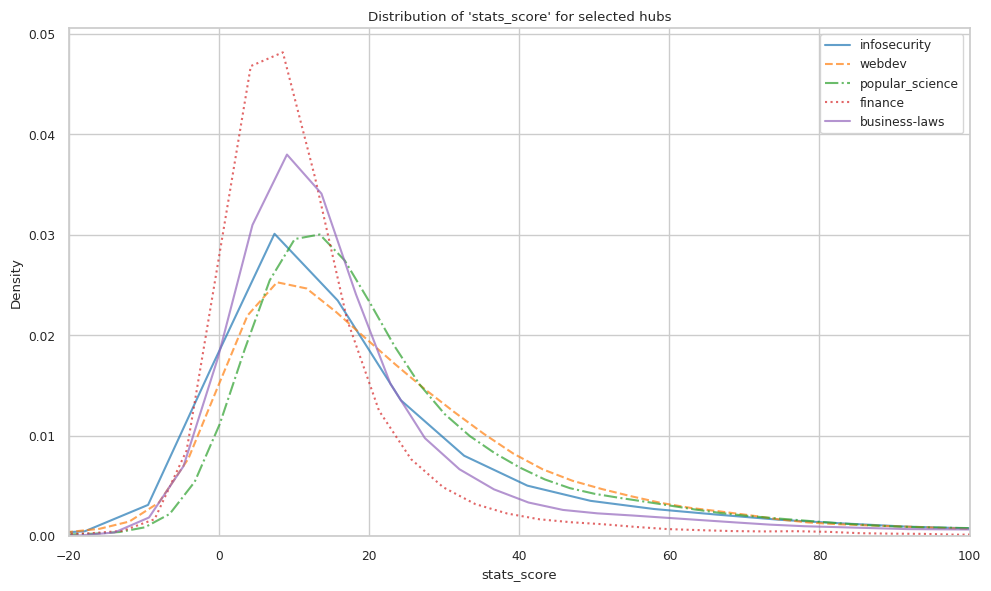

In [18]:
plot_hub_distributions(filtered_df, hubs_for_analysis, "stats_score", xlim=(-20, 100))

We also can't mention that we already saw that the classes are not balances, but let's look at this more carefully.

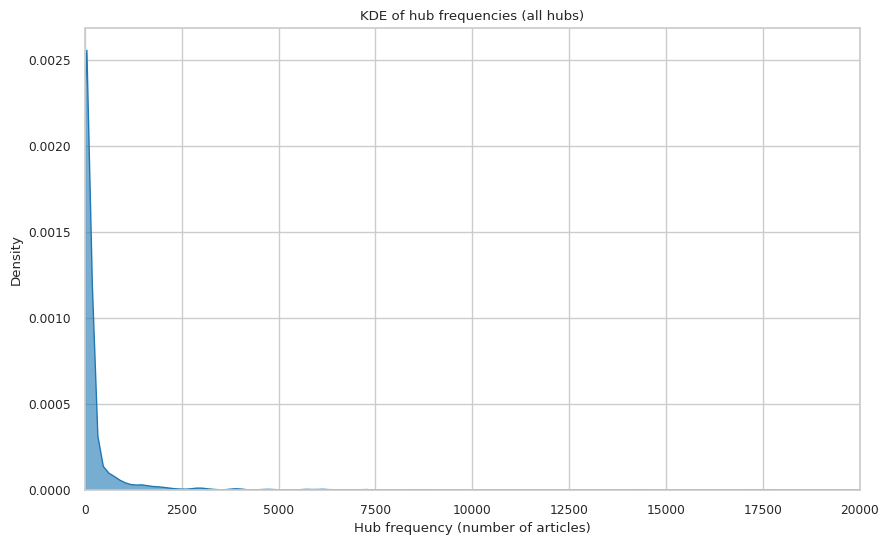

In [19]:
counts = np.array(list(hub_counts.values()))

plt.figure(figsize=(10, 6))
sns.kdeplot(counts, bw_adjust=0.5, fill=True, alpha=0.6)
plt.xlabel("Hub frequency (number of articles)")
plt.ylabel("Density")
plt.title("KDE of hub frequencies (all hubs)")

plt.xlim((-10, 20_000))
plt.show()

We see that most of the hubs appear rarely, while some of them are quite popular (which we analysed above). For example, let's look at the statistics:

In [20]:
counts_series = pd.Series(counts)
counts_series.describe()

count     2558.000000
mean       265.270133
std       1199.454769
min          1.000000
25%          3.000000
50%         11.000000
75%         60.000000
max      27447.000000
dtype: float64

We can see that `q2` is about 11, while the mean value is about 265. It shows us that the tails are incredibly heavy.

**Conclusion.** As a result, we may assume how the hubs are working. We have some "most popular" or "most common" (for example `infosecurity`) which are assigned to all (or almost all) the related articles, while most of the hubs are quite rare. 

## Statistics Dynamics

For this section let's download `text_length`, `statistics` and `timestamps` and look at how they have been changing over the time.

In [21]:
columns_to_load = ["id", "text_markdown", "time_published", "statistics"]

dataset = data_loader.HabrDataset(
    path=DEFAULT_FULL_PATH, columns=columns_to_load, batch_size=50_000
)

all_batches = []
for batch_df in dataset:
    batch_df["text_length"] = batch_df["text_markdown"].str.len()
    batch_df = batch_df.drop(columns=["text_markdown"])

    stats_df = batch_df["statistics"].apply(pd.Series)
    stats_df = stats_df.rename(columns=lambda x: f"stats_{x}")

    batch_df = pd.concat([batch_df.drop(columns=["statistics"]), stats_df], axis=1)

    all_batches.append(batch_df)

full_df = pd.concat(all_batches, ignore_index=True)
full_df["time_published"] = pd.to_datetime(full_df["time_published"], unit="s")

filtered_df = full_df[full_df.id.isin(filtered_ids)].copy()

filtered_df.head()

Reading dataset: 302049it [02:35, 1937.35it/s]


,id,time_published,text_length,stats_commentsCount,stats_favoritesCount,stats_readingCount,stats_score,stats_votesCount,stats_votesCountPlus,stats_votesCountMinus
0,12730,2007-08-01 09:59:40,608,23,1,1542,7,15,11,4
1,558542,2021-05-21 06:20:24,10237,3,17,7229,6,6,6,0
2,141150,2012-03-31 17:24:02,1830,10,22,1711,20,24,22,2
3,530546,2020-11-30 09:09:28,6698,1,7,2737,8,8,8,0
4,598357,2021-12-28 11:01:02,9667,101,78,35519,79,83,81,2


Now we can show how the statistics changed over the time.

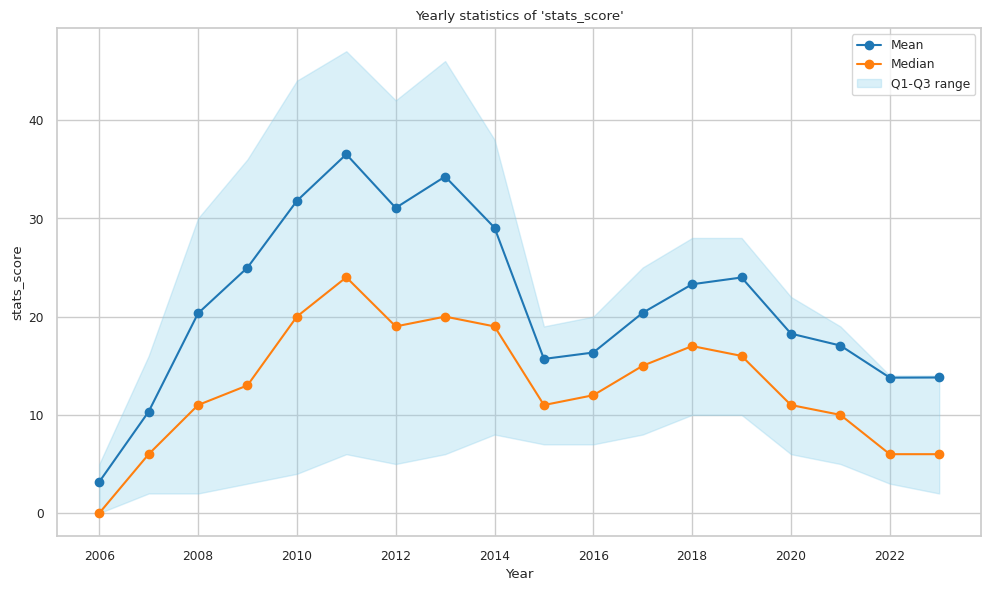

In [22]:
def plot_yearly_stats(df, column_name, date_column="time_published", figsize=(10, 6)):
    """
    Plot average and interquartile range (Q1-Q3) of a numeric column per year.
    """

    df[date_column] = pd.to_datetime(df[date_column])

    df["year"] = df[date_column].dt.year

    stats = df.groupby("year")[column_name].agg(
        [
            ("Q1", lambda x: x.quantile(0.25)),
            ("Median", "median"),
            ("Q3", lambda x: x.quantile(0.75)),
            ("Mean", "mean"),
        ]
    )

    plt.figure(figsize=figsize)
    plt.plot(stats.index, stats["Mean"], marker="o", label="Mean")
    plt.plot(stats.index, stats["Median"], marker="o", label="Median")
    plt.fill_between(
        stats.index,
        stats["Q1"],
        stats["Q3"],
        color="skyblue",
        alpha=0.3,
        label="Q1-Q3 range",
    )
    plt.xlabel("Year")
    plt.ylabel(column_name)
    plt.title(f"Yearly statistics of '{column_name}'")
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


plot_yearly_stats(filtered_df, "stats_score")

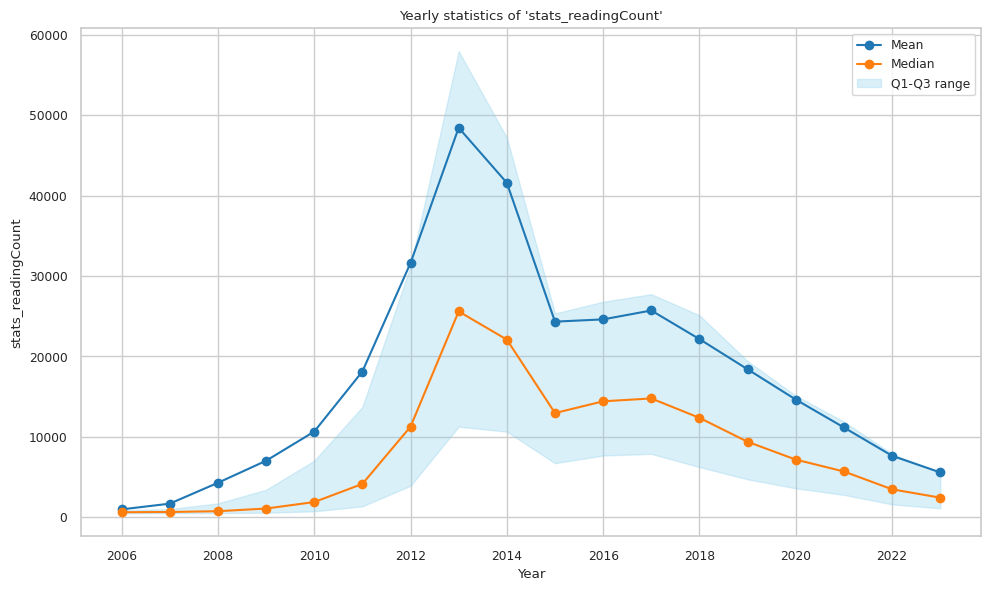

In [23]:
plot_yearly_stats(filtered_df, "stats_readingCount")

Let's try to understand them. Based on the second graph we see that habr rocketed in 2010-2014 years. After reaching it's peak it started steadily declining.

In the first graph we see the highest average scores in the same years. After some fluctuation we see a gradual fall.

Let's also check the amount of the aritcles to confirm these conclusions.

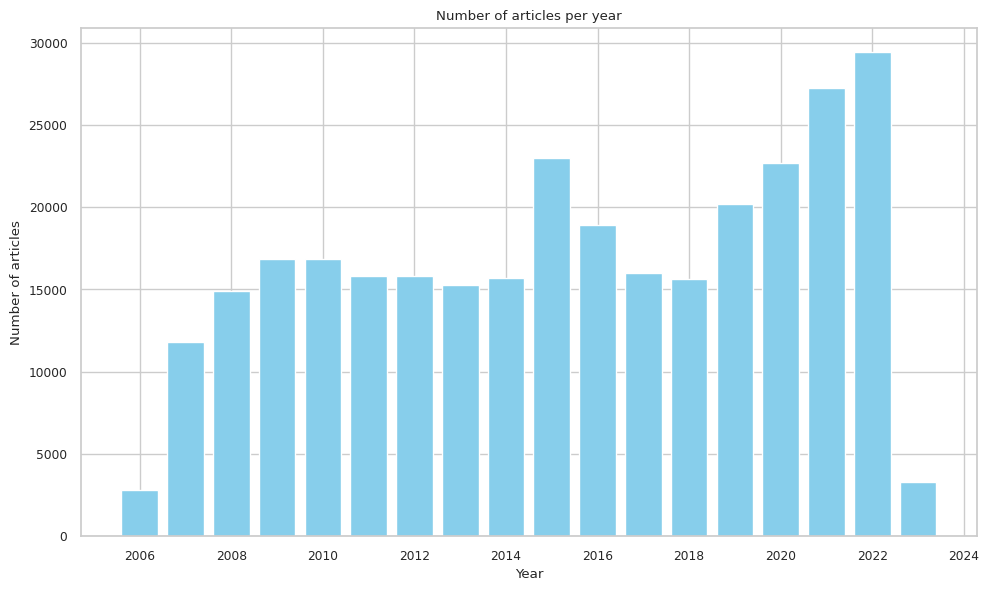

In [24]:
filtered_df["year"] = filtered_df["time_published"].dt.year
counts = filtered_df.groupby("year").size()

plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color="skyblue")
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Number of articles per year")
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

Well, now the effect is even more interesting. We see that amount of the articles wasn't decreasing over the time, while the statistics (including `readingCount`) slumped after 2014.

As a last step, let's visualise the change of the length.

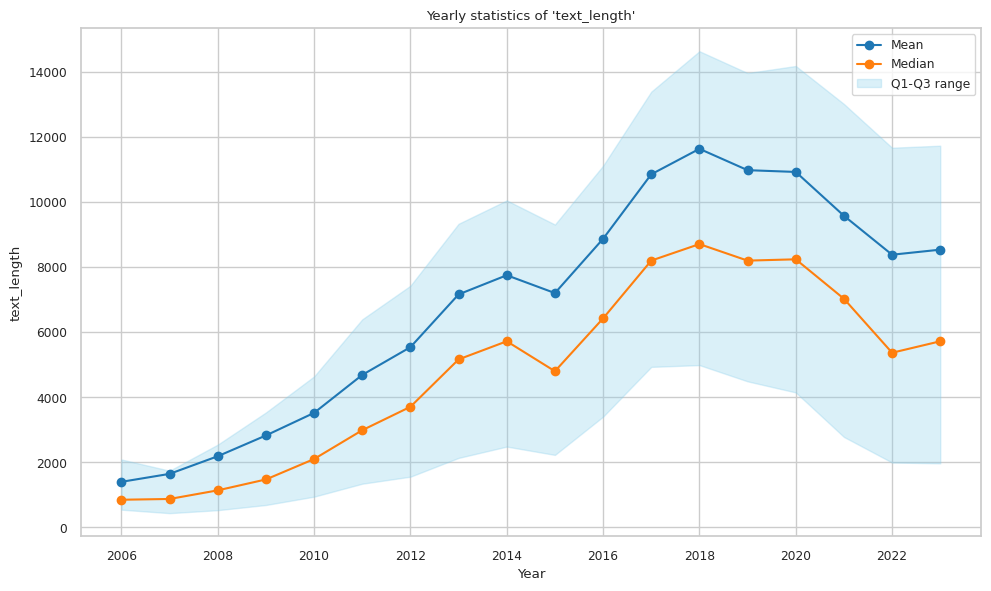

In [25]:
plot_yearly_stats(filtered_df, "text_length")

We can see that the texts were getting bigger over the time, however the length bounced back after 2020.

**Conclusion.** We noticed the significant changes for the statistics over the time. However, we still won't use this metadata for our model, so we won't be able to include them.

## Words analysis

For the last section let's take a look at the texts and plot some graps. Let's download the necessary columns.

In [26]:
columns_to_load = ["id", "text_markdown", "language"]

dataset = data_loader.HabrDataset(
    path=DEFAULT_FULL_PATH, columns=columns_to_load, batch_size=50_000
)

Let's count the words for each language and draw the wordclouds.

Reading dataset: 302049it [04:30, 1115.37it/s]


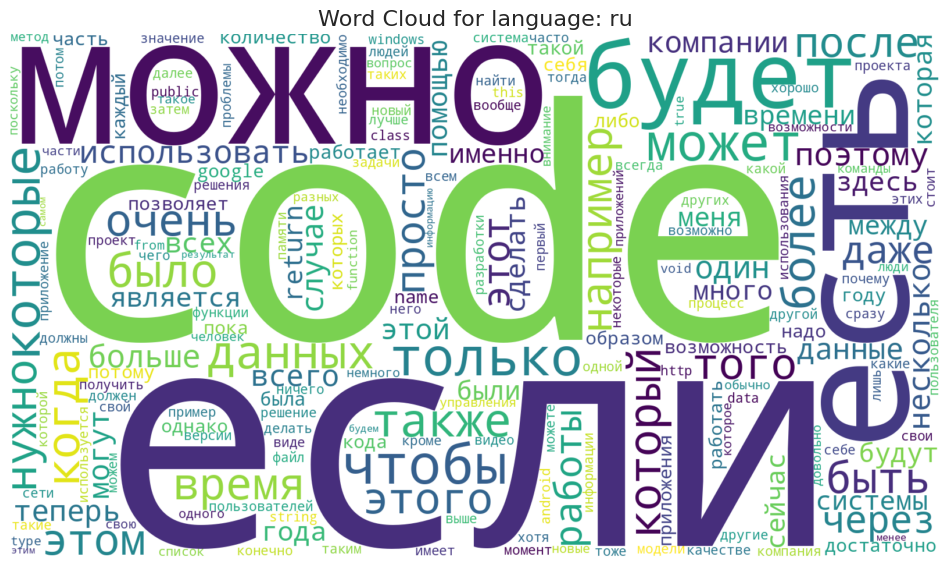

In [27]:
def generate_wordcloud_from_dataset(
    dataset,
    column_name="text_markdown",
    language=None,
    max_words=200,
    min_word_length=3,
    figsize=(12, 8),
):
    word_counter = Counter()

    for batch_df in dataset:
        if language is not None and "language" in batch_df.columns:
            batch_df = batch_df[batch_df["language"] == language]

        texts = batch_df[column_name].dropna().astype(str)
        for text in texts:
            words = re.findall(r"\b\w+\b", text.lower())
            filtered_words = [w for w in words if len(w) >= min_word_length]
            word_counter.update(filtered_words)

    if not word_counter:
        print(f"No words found for language: {language}")
        return Counter()

    wordcloud = WordCloud(
        width=1600,
        height=900,
        max_words=max_words,
        background_color="white",
        colormap="viridis",
    ).generate_from_frequencies(word_counter)

    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    title = (
        f"Word Cloud for language: {language}"
        if language
        else "Word Cloud of Most Frequent Words"
    )
    plt.title(title, fontsize=16)
    plt.show()


generate_wordcloud_from_dataset(dataset, language="ru", min_word_length=4)

We see that even for `language="ru"` some of the most popular words are not actually Russian. However, to understand this data better we will analyse the distribution of various parts of the speech (POS) instead. Run it for the whole dataset would take some incredible amount of time, so instead we will run it only on the first 1000 texts.

Reading dataset: 1099it [00:00, 2546.53it/s]


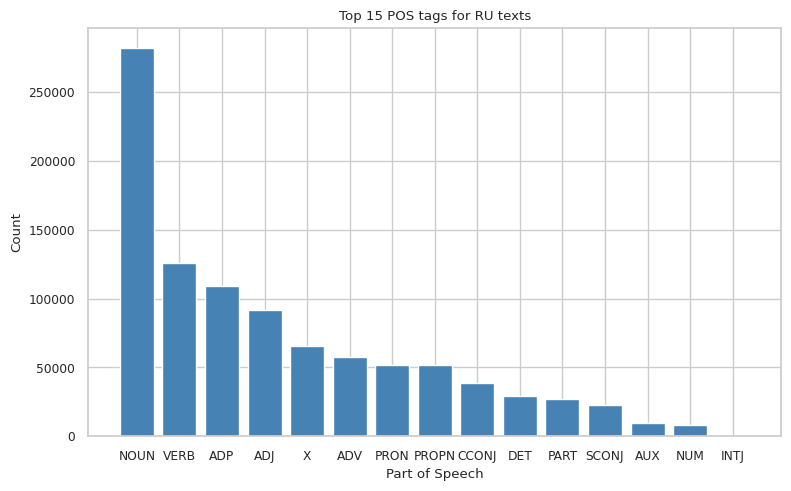

Counter({'NOUN': 282338,
         'VERB': 125689,
         'ADP': 109132,
         'ADJ': 91779,
         'X': 65410,
         'ADV': 57618,
         'PRON': 51836,
         'PROPN': 51712,
         'CCONJ': 38682,
         'DET': 29426,
         'PART': 26728,
         'SCONJ': 22952,
         'AUX': 9545,
         'NUM': 8367,
         'INTJ': 124,
         'SYM': 93,
         'PUNCT': 11})

In [28]:
columns_to_load = ["id", "text_markdown", "language"]

dataset_small_batch = data_loader.HabrDataset(
    path=DEFAULT_FULL_PATH, columns=columns_to_load, batch_size=100
)


def count_pos_from_dataset(
    dataset,
    column_name="text_markdown",
    language="ru",
    top_n=15,
    min_texts_to_analyse=None,
):
    """
    Count POS tags from a dataset, processing batches until at least `min_texts_to_analyse` texts
    of the given language are found.
    """
    model_name = "ru_core_news_sm" if language == "ru" else "en_core_web_sm"

    try:
        nlp = spacy.load(model_name, disable=["ner", "parser"])
    except OSError:
        from spacy.cli import download

        download(model_name)
        nlp = spacy.load(model_name, disable=["ner", "parser"])

    pos_counter = Counter()
    texts_to_process = []

    for batch_df in dataset:
        if "language" in batch_df.columns:
            batch_df = batch_df[batch_df["language"] == language]

        texts = batch_df[column_name].dropna().astype(str).tolist()
        texts_to_process.extend(texts)

        if min_texts_to_analyse and len(texts_to_process) >= min_texts_to_analyse:
            break

    if not texts_to_process:
        print(f"No texts found in language '{language}'.")
        return pos_counter

    for doc in nlp.pipe(texts_to_process, batch_size=128, n_process=4):
        pos_counter.update(token.pos_ for token in doc if token.is_alpha)

    top_pos = pos_counter.most_common(top_n)
    pos_df = pd.DataFrame(top_pos, columns=["POS", "Count"])

    plt.figure(figsize=(8, 5))
    plt.bar(pos_df["POS"], pos_df["Count"], color="steelblue")
    plt.title(f"Top {top_n} POS tags for {language.upper()} texts")
    plt.xlabel("Part of Speech")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    return pos_counter


count_pos_from_dataset(dataset_small_batch, language="ru", min_texts_to_analyse=1000)

This says us a lot.

**Conclusion.** The majority of words in these texts are nouns, which indicates that the content is primarily technical or informational, with relatively little narrative or expressive content.